# Face Detection using PCA


## Assignment 1 (4 scores): Implement PCA using Numpy.

In [1]:
import numpy as np

In [2]:
class PrincipleComponentAnalysis:
  def __init__(self, n_components: int = 1):
    self.n_components = n_components
    self.eigenvalues_selected = None
    self._eigenvectors_selected = None

  def fit(self, X: np.ndarray):
    #TÍNH MA TRẬN HIỆP PHƯƠNG SAI
    cov = np.cov(X, rowvar = False)

    #TÍNH GIÁ TRỊ RIÊNG VÀ VECTOR RIÊNG
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    #ĐƯA DẤU CÁC EIGENVECTORS VỀ CÙNG DƯƠNG
    for i in range(eigenvectors.shape[1]):
      if np.sign(np.sum(eigenvectors[:, i])) < 0:
        eigenvectors[:,i] *= -1

    #SẮP XẾP THEO THỨ TỰ GIẢM DẦN
    eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(eigenvectors.shape[1])]
    eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)

    #CHUYỂN VỀ DẠNG MA TRẬN
    eigenvalues = np.array([value for (value, _) in eigen_pairs])
    eigenvectors = np.array([vector for (_, vector) in eigen_pairs])

    #CHỌN THUỘC TÍNH
    self.eigenvalues_selected = eigenvalues[:self.n_components]
    self._eigenvectors_selected = eigenvectors[:self.n_components]

  def transform(self, X: np.ndarray) -> np.ndarray:
    X_hat = X @ self._eigenvectors_selected.T
    return X_hat

## Assignment 2 (4 scores):

### Reading the training images.

In [3]:
import os
import random
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize

In [7]:
! unzip /content/drive/MyDrive/uit/DS102/yalefaces.zip

Archive:  /content/drive/MyDrive/uit/DS102/yalefaces.zip
   creating: yalefaces/
   creating: yalefaces/person-4/
  inflating: yalefaces/person-4/rightlight  
  inflating: yalefaces/person-4/leftlight  
  inflating: yalefaces/person-4/normal  
  inflating: yalefaces/person-4/noglasses  
  inflating: yalefaces/person-4/happy  
  inflating: yalefaces/person-4/centerlight  
  inflating: yalefaces/person-4/sleepy  
  inflating: yalefaces/person-4/glasses  
  inflating: yalefaces/person-4/wink  
  inflating: yalefaces/person-4/surprised  
   creating: yalefaces/person-15/
  inflating: yalefaces/person-15/rightlight  
  inflating: yalefaces/person-15/leftlight  
  inflating: yalefaces/person-15/normal  
  inflating: yalefaces/person-15/noglasses  
  inflating: yalefaces/person-15/sad  
  inflating: yalefaces/person-15/centerlight  
  inflating: yalefaces/person-15/sleepy  
  inflating: yalefaces/person-15/glasses  
  inflating: yalefaces/person-15/wink  
  inflating: yalefaces/person-15/surp

In [6]:
BASE_DIR = 'yalefaces'
person_folders = {
    'person-1',
    'person-2',
    'person-3',
    'person-4',
    'person-5',
    'person-6',
    'person-7',
    'person-8',
    'person-9',
    'person-10',
    'person-11',
    'person-12',
    'person-13',
    'person-14',
    'person-15'
}

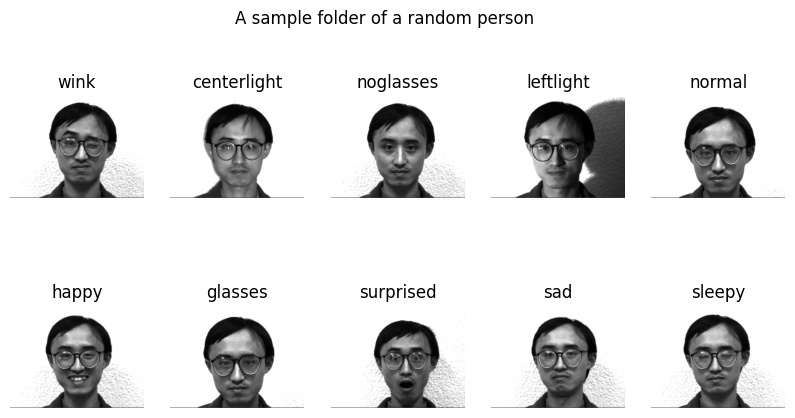

In [8]:
person_folder = random.choice(list(person_folders))
folder_path = os.path.join(BASE_DIR, person_folder)

plt.figure(figsize=(10,5))
for i_th, filename in enumerate(os.listdir(folder_path)):
  image_path = os.path.join(folder_path, filename)
  image = imread(image_path)
  image = image.squeeze()
  plt.subplot(2,5,i_th+1)
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.title(filename)
plt.suptitle('A sample folder of a random person')
plt.show()

In [9]:
data = {}

for person_folder in person_folders:
  for filename in os.listdir(os.path.join(BASE_DIR, person_folder)):
    image = imread(os.path.join(BASE_DIR, person_folder, filename))
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    if person_folder not in data:
      data[person_folder] = [image]
    else:
      data[person_folder].append(image)

for person in data:
  data[person] = np.concat(data[person], axis=0).reshape(10,-1)

### Approximating the Principle Space having **20 dimensions**.

In [10]:
PCA = PrincipleComponentAnalysis(n_components=20)

In [11]:
def standardizing(images: np.ndarray) -> np.ndarray:
  images = (images - images.mean()) / images.std()
  images = images.astype(np.float32)
  return images

In [12]:
images = []
for person in data:
  images.append(data[person])
images = np.concat(images, axis=0)
images = standardizing(images)
images.shape

(150, 5120)

In [13]:
PCA.fit(images)

In [14]:
PCA._eigenvectors_selected.shape

(20, 5120)

### Visualize the base of this Principle Space.

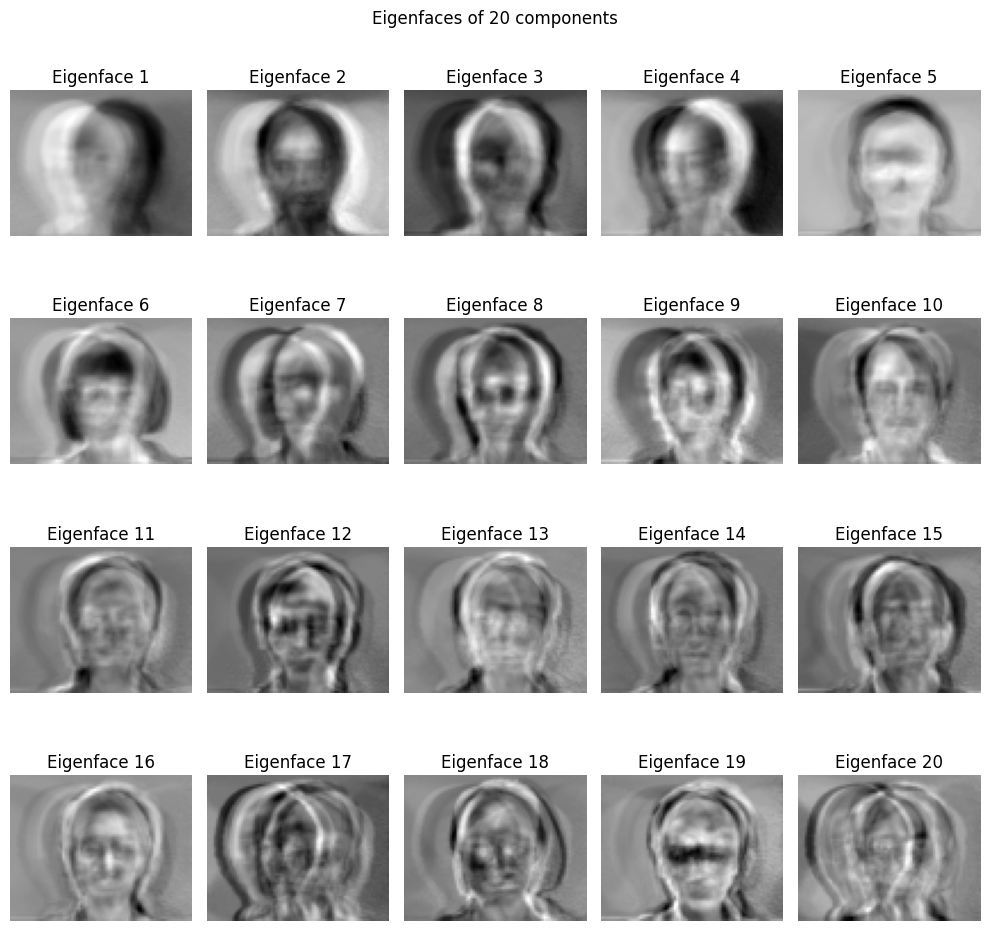

In [15]:
eigenfaces = PCA._eigenvectors_selected
eigenfaces = eigenfaces.reshape(20, 64, 80)
plt.figure(figsize=(10,10))
for i_th, eigenface in enumerate(eigenfaces):
  plt.subplot(4,5,i_th+1)
  plt.imshow(eigenface, cmap='gray')
  plt.axis('off')
  plt.title(f'Eigenface {i_th+1}')
plt.suptitle('Eigenfaces of 20 components')
plt.tight_layout()
plt.show()

## Assignment 3 (2 scores):

### Assign persons to the face images in testing data.

In [45]:
mean_faces = {person: np.mean(images, axis=0) for person, images in data.items()}

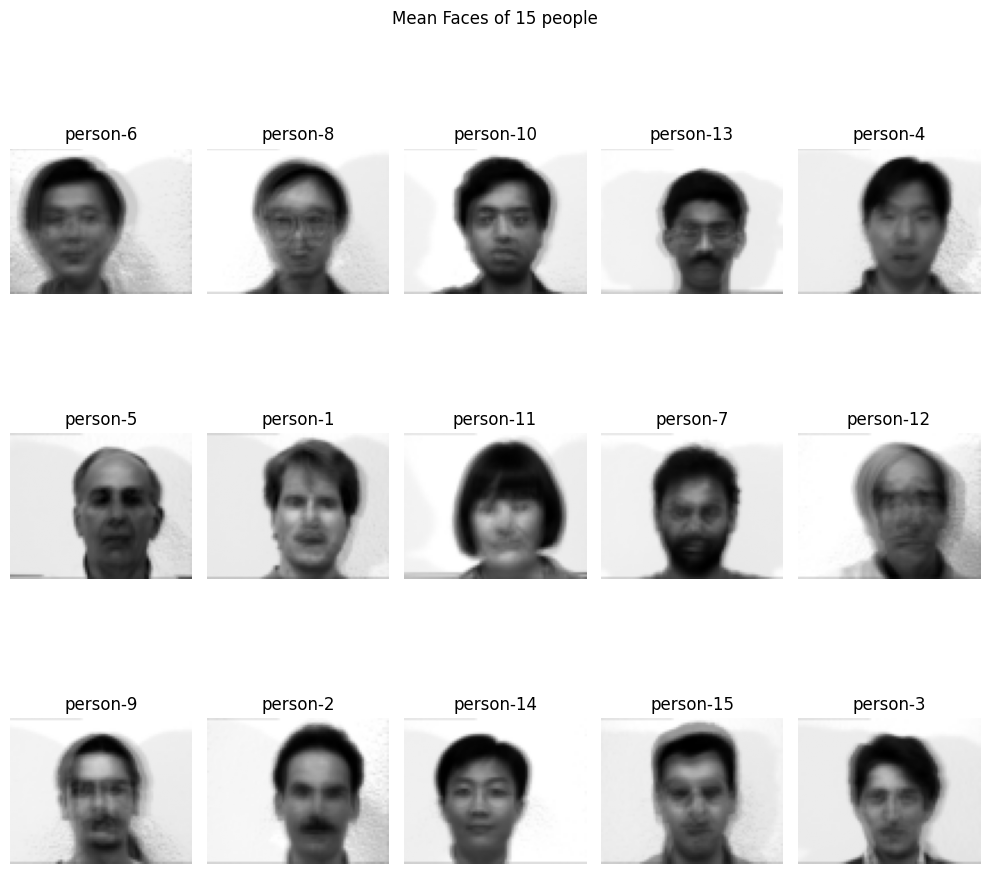

In [46]:
plt.figure(figsize=(10,10))
for i_th, person in enumerate(mean_faces):
  mean_face = mean_faces[person]
  mean_face = mean_face.reshape(64, 80)
  plt.subplot(3,5,i_th+1)
  plt.imshow(mean_face, cmap='gray')
  plt.axis('off')
  plt.title(person)
plt.suptitle('Mean Faces of 15 people')
plt.tight_layout()
plt.show()

In [47]:
pca_mean_faces = {}
for person in mean_faces:
  pca_mean_faces[person] = PCA.transform(mean_faces[person])

In [48]:
labels = []
test_images = []
TEST_DIR = '/content/yalefaces/test'
for filename in os.listdir(TEST_DIR):
  person_name = filename.split('.')[0]
  labels.append(person_name)
  image = imread(os.path.join(TEST_DIR, filename))
  image = resize(image, (1, 64, 80), anti_aliasing=True)
  test_images.append(image)

In [49]:
test_images = np.concat(test_images, axis=0)
test_images.shape

(15, 64, 80)

In [50]:
def Euclide_distance(X: np.ndarray, Y: np.ndarray):
  assert X.shape == Y.shape, f'{X.shape} and {Y.shape} are miss-shaped'
  return (((X - Y) ** 2).sum()) ** 0.5

In [54]:
predictions = {}

for label, image in zip(labels, test_images):
  image = image.reshape(-1)
  closest_distance = np.inf
  closest_person = None

  for person in pca_mean_faces:
    distance = Euclide_distance(PCA.transform(image), pca_mean_faces[person])

    if distance < closest_distance:
      closest_distance = distance
      closest_person = person

  predictions[label] = closest_person

In [56]:
for i, (label, predicted_label) in enumerate(predictions.items()):
    print(f'True: {label}\nPred: {predicted_label}\n')

True: person-4
Pred: person-4

True: person-2
Pred: person-12

True: person-8
Pred: person-15

True: person-7
Pred: person-7

True: person-11
Pred: person-11

True: person-1
Pred: person-1

True: person-10
Pred: person-10

True: person-9
Pred: person-9

True: person-6
Pred: person-14

True: person-13
Pred: person-13

True: person-3
Pred: person-3

True: person-5
Pred: person-5

True: person-15
Pred: person-15

True: person-12
Pred: person-2

True: person-14
Pred: person-12



### Evaluate the accuracy of this face recognition system.

In [58]:
correct_pred = []
for label in predictions:
  correct_pred.append(label == predictions[label])

print(f'Correct: {sum(correct_pred)}')
print(f'Incorrect: {len(correct_pred) - sum(correct_pred)}')

Correct: 10
Incorrect: 5


In [59]:
print(f'Accurary: {(np.mean(correct_pred)*100):0.2f} %')

Accurary: 66.67 %
